In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import math
from datetime import date, datetime

from matplotlib import pyplot as plt
import matplotlib.dates as dates

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load dataset of climate indices

In [2]:
df_cidx = pd.read_csv('/mnt/efs/data/climate_indices.csv')
df_cidx.head()

,time,year,month,tsa,nino4,ao,atltri,nao_jones,epo,amon_sm,...,random,trend_neg,ssh_pc1,ssh_pc2,ssh_dtr_pc1,ssh_dtr_pc2,fkl,fkl_anom,moc,moc_ht
0,1950-01-15,1950,1,0.08,26.94,-0.060,-0.571,0.55,0.91,0.097,...,-0.598961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-02-15,1950,2,0.15,26.67,0.627,-1.106,3.31,-1.13,0.095,...,-0.389413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1950-03-15,1950,3,0.12,26.52,-0.008,-0.620,0.82,-0.02,0.092,...,0.941117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1950-04-15,1950,4,-0.17,26.90,0.555,-0.230,1.61,-1.87,0.090,...,0.579001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1950-05-15,1950,5,-0.34,27.73,0.072,-0.279,-1.73,-0.98,0.088,...,1.877807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# climidx_corr() #

climidx_corr() is a function that calculates the correlation of a data array to the given climate indices stored in the data frame of climate indices (df_cidx).

``climidx_corr(df_cidx, df, col, rmean=None, ave=1, lag=None, unify=False, tmin=None, tmax=None, method =‘pearson’)``

#### df_cidx
DataFrame of climate indices

#### df
DataFrame of some time series

#### col
Column name of time series in df DataFrame that is correlated with climate indices in df_cidx 

#### rmean
Number of months to apply running mean to time series (for both data and climate indices)

#### ave
Number of months to average
Example:
- If data (or tmin) starts at January, ‘ave=3’ will give averages of jfm, amj, jas, ond for each year and ’ave=12’ will give averages of full years.
- If data (or tmin) starts at February, ‘ave=3’ will give averages of fma, mjj, aso, ndj for each year and ‘ave=12’ will lead to averages of full years between february of a given year to january of the following year

#### lag
Lag of months that data time series is leading with respect to climate indices. Positive lag values indicate data time series leads climate indices; negative lag values means data lags climate indices.

#### unify
NaN need to be removed from the climate indices. If unify=False, data is correalted with a given climate indices where both arrays are not NaN. If unify=True, all climate indices need to have the same length of value, such that data is correalted with a given climate indices where all arrays (data + all time indices) are not NaN. For example, if nao=NaN at 1978-05, then correlation of all other climate indices will be evaluated without 1978-05.

#### tmin
lower limit of year and month (‘yyyy-mm’)

#### tmax
upper limit of year and month (‘yyyy-mm’)

#### method
{‘pearson’, ‘kendall’, ‘spearman’}
- pearson : standard correlation coefficient
- kendall : Kendall Tau correlation coefficient
- spearman : Spearman rank correlation

In [3]:
def climidx_corr(climate_indices, data, col, rmean=None, ave=1, lag=None, unify=False, tmin=None, tmax=None, method ='pearson'):
    
    # check that the datetime datatypes are correct
    climate_indices['time'] = pd.DatetimeIndex(climate_indices['time'])
    data['time'] = pd.DatetimeIndex(data['time'])
    
    # add data values to climate indices to use one data frame later
    climate_indices = climate_indices.set_index(['time'])
    data = data.set_index(['time'])
    
    climate_indices['data'] = data[col]
    climate_indices.reset_index(inplace=True)
    # drop NaNs for data column
    climate_indices.dropna(subset=['data'],inplace=True)
    # sort records
    climate_indices.sort_values(by = 'time', inplace=True)
    
    # drop NaNs more more extensive if needed
    if unify == True:
        climate_indices.dropna(inplace=True)
    # in other case data is correalted with a given climate indices where both arrays are not NaN
        
    # Lag of months that data time series is leading with respect to climate indices.
    if not lag is None and lag != 0:
        if lag > 0:
            # Positive lag values indicate data time series leads climate indices
            climate_indices['data'] = np.concatenate([climate_indices['data'][lag:],lag*[np.nan]])
        else:
            #negative lag values means data lags climate indices.
            climate_indices['data'] = np.concatenate([-lag*[np.nan],climate_indices['data'][:lag]])
    
    # lower limit of year and month
    if not tmin is None:
        climate_indices = climate_indices[(climate_indices.time >= tmin)]
    if not tmax is None:
        climate_indices = climate_indices[(climate_indices.time <= tmax)]
    
    # ave is number of months to average starting of the 1st month in the dataset
    if not ave is None and ave > 0:
        climate_indices['idx'] = range(1, len(climate_indices) + 1)
        climate_indices['ave'] = [int(math.ceil(1.*idx/ave)) for idx in climate_indices['idx']]
        climate_indices = climate_indices.groupby(['ave']).mean()
    
    result = {}
    for col in climate_indices.columns.values.tolist():
        if col in ['time','year','month','data','idx','ave']:
            continue
        # drop NaNs for case when unify == False (there is no action when unify == True)
        df = climate_indices[[col,'data']].dropna()
        
        # apply running mean to time series (for both data and climate indices)
        # should be used when NaNs filtered!
        # some first and last items will be NaNs after
        if not rmean is None and rmean > 1:
            df = df.rolling(window = rmean, center = True).mean().dropna()
        
        if method == 'pearson':
            r,p = stats.pearsonr(df[col], df['data'])
        elif method == 'kendall':
            r,p = stats.stats.kendalltau(df[col], df['data'])
        elif method == 'spearman':
            r,p = stats.stats.spearmanr(df[col], df['data'])
        else:
            r,p = None,None
        result[col] = [r,p]

    return pd.DataFrame.from_dict(result, orient='index').rename(columns={0:'corr', 1:'pvalue'}).sort_values(by = 'pvalue')

### Load data file

In [4]:
df_fw = pd.read_csv('/mnt/efs/data/eccov4_spna_fw_flx.csv')
df_ht = pd.read_csv('/mnt/efs/data/eccov4_spna_heat_flx.csv')

In [5]:
def convert_time(df):
    df.time = pd.DatetimeIndex(df.time)
    df['year'], df['month'] = df['time'].dt.year, df['time'].dt.month
    df.drop(columns=['time'],inplace=True)
    df['time'] = pd.DatetimeIndex([datetime(year, month, 15) for (year,month) in zip(df.year, df.month)])
    
    return df

In [6]:
df_fw = convert_time(df_fw)
df_ht = convert_time(df_ht)

In [7]:
print(climidx_corr(df_cidx, df_fw, 'total', lag=None, ave=12, rmean=None, unify=None,
                   tmin='1993-01-15', tmax='2015-12-15', method='pearson'))

                 corr    pvalue
ssh_dtr_pc1  0.541018  0.007682
ssh_pc2      0.475648  0.021791
trend        0.469621  0.023763
trend_neg   -0.469621  0.023763
ao           0.469173  0.023915
nao_jones    0.729274  0.025775
ssh_dtr_pc2 -0.393692  0.063075
sahelrain    0.386468  0.068516
amm         -0.350954  0.100597
pacwarm     -0.396066  0.128849
moc_ht       0.311399  0.148069
tna         -0.302721  0.160308
fkl         -0.302235  0.161014
amon_sm      0.296667  0.169255
fkl_anom    -0.291562  0.177064
NTA_ersst   -0.282497  0.191536
CAR_ersst    0.278686  0.197855
nao          0.271546  0.210068
np           0.269892  0.212968
gmsst        0.249856  0.250228
aao          0.223849  0.304525
glaam       -0.218707  0.328146
tsa         -0.198613  0.363618
moc          0.192883  0.377900
atltri      -0.226678  0.398539
pdo         -0.179596  0.412228
ssh_pc1     -0.177924  0.416666
eofpac      -0.201944  0.453236
nino1        0.152248  0.487998
swmonsoon    0.174333  0.489024
brazilra

In [8]:
print(climidx_corr(df_cidx, df_ht, 'total', lag=None, ave=None, rmean=None, unify=None,
                   tmin='1993-01-15', tmax='2015-12-15', method='pearson'))

                 corr        pvalue
moc_ht      -0.616307  3.701587e-30
moc         -0.525944  5.783943e-21
ao          -0.498834  1.043999e-18
ssh_dtr_pc1 -0.442797  1.239717e-14
nao         -0.423679  2.093670e-13
ssh_pc2     -0.416381  5.881788e-13
nao_jones   -0.609047  8.733318e-12
NTA_ersst    0.327411  2.717572e-08
tna          0.321435  4.995381e-08
amm          0.280144  2.366098e-06
atltri       0.307169  1.544434e-05
pdo          0.210221  4.488716e-04
trend_neg    0.209173  4.800447e-04
trend       -0.209173  4.800447e-04
amon_us      0.189770  1.570012e-03
ssh_dtr_pc2  0.151108  1.211223e-02
amon_sm     -0.135892  2.667918e-02
espi         0.120990  4.500365e-02
meiv2        0.113666  5.977486e-02
np          -0.113540  6.005875e-02
glaam        0.114984  6.731383e-02
solar       -0.109707  6.929521e-02
fkl_anom    -0.109590  6.959466e-02
noi         -0.134184  7.839300e-02
best         0.094916  1.163250e-01
fkl         -0.086082  1.545493e-01
qbo         -0.085697  1.564

In [9]:
df_sub = df_cidx.set_index('time')[['nao','ao']].loc['1993-01-01':'2015-11-30']
df_sub['advConv_fw'] = df_fw.set_index('time')['total']
df_sub['advConv_ht'] = df_ht.set_index('time')['total']

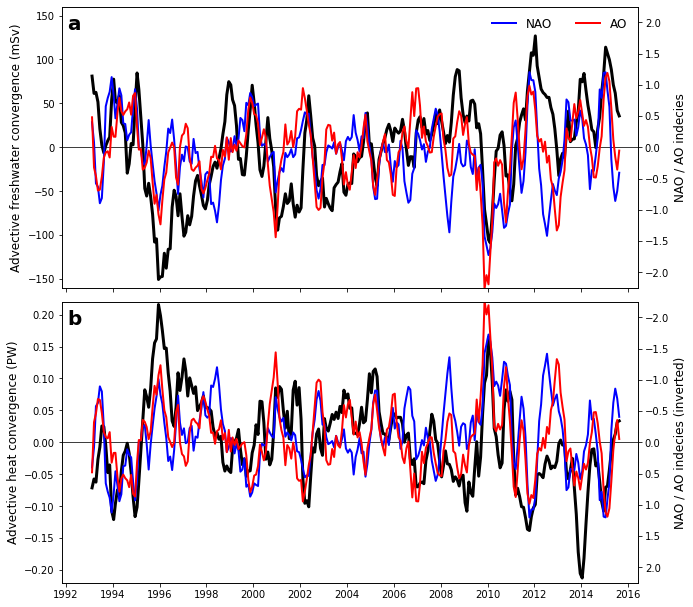

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05)

axs[0].text(0.01,0.92, 'a', fontsize=20, fontweight='bold', transform=axs[0].transAxes)
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axs[0].plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_fw']*1e3, 
            lw=3, color='k', linestyle='-')
axs[0].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[0].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[0].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[0].set_ylim([-160,160])
axs[0].set_ylabel(r'Advective freshwater convergence (mSv)', fontsize=12)
#ax1.invert_yaxis()

axa = axs[0].twinx()
axa.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axa.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['nao'], lw=2, color='b',linestyle='-',label='NAO')
axa.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['ao'], lw=2, color='r',linestyle='-',label='AO')
axa.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axa.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axa.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axa.set_ylim([-2.25,2.25])
#axa.invert_yaxis()
axa.set_ylabel(r'NAO / AO indecies', fontsize=12)
axa.legend(loc='upper right',frameon=False, ncol=2, fontsize=12)

axs[1].text(0.01,0.92, 'b', fontsize=20, fontweight='bold', transform=axs[1].transAxes)
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axs[1].plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_ht'], lw=3, color='k', linestyle='-')
axs[1].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[1].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[1].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[1].set_ylim([-0.22,0.22])
axs[1].set_ylabel(r'Advective heat convergence (PW)', fontsize=12)
#ax1.invert_yaxis()

axb = axs[1].twinx()
axb.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axb.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['nao'], lw=2, color='b',linestyle='-',label='NAO')
axb.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['ao'], lw=2, color='r',linestyle='-',label='AO')
axb.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axb.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axb.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axb.set_ylim([-2.25,2.25])
axb.invert_yaxis()
axb.set_ylabel(r'NAO / AO indecies (inverted)', fontsize=12)
#axb.legend(loc='lower left',frameon=False, ncol=2, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [11]:
df_sub.corr()
#0.469173  0.023915
#0.271546  0.210068

,nao,ao,advConv_fw,advConv_ht
nao,1.000000,0.653826,0.347441,-0.423679
ao,0.653826,1.000000,0.422093,-0.498834
advConv_fw,0.347441,0.422093,1.000000,-0.690953
advConv_ht,-0.423679,-0.498834,-0.690953,1.000000


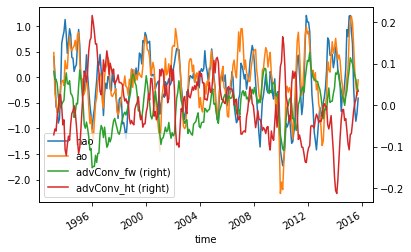

In [12]:
df_sub.rolling(window=5,center=True).mean().plot(secondary_y=['advConv_fw','advConv_ht'])

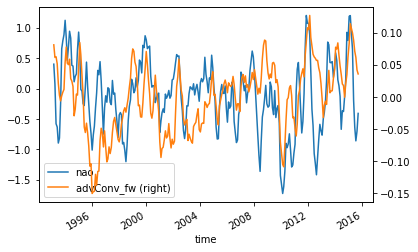

In [13]:
df_sub[['nao','advConv_fw']].rolling(window=5,center=True).mean().plot(secondary_y=['advConv_fw'])

In [14]:
df_sub.rolling(window=5,center=True).mean().corr()

,nao,ao,advConv_fw,advConv_ht
nao,1.000000,0.698170,0.355443,-0.425658
ao,0.698170,1.000000,0.480052,-0.557173
advConv_fw,0.355443,0.480052,1.000000,-0.816645
advConv_ht,-0.425658,-0.557173,-0.816645,1.000000


In [17]:
df_sub['advConv_fw_norm'] = (df_sub.advConv_fw - df_sub.advConv_fw.mean())/df_sub.advConv_fw.std()

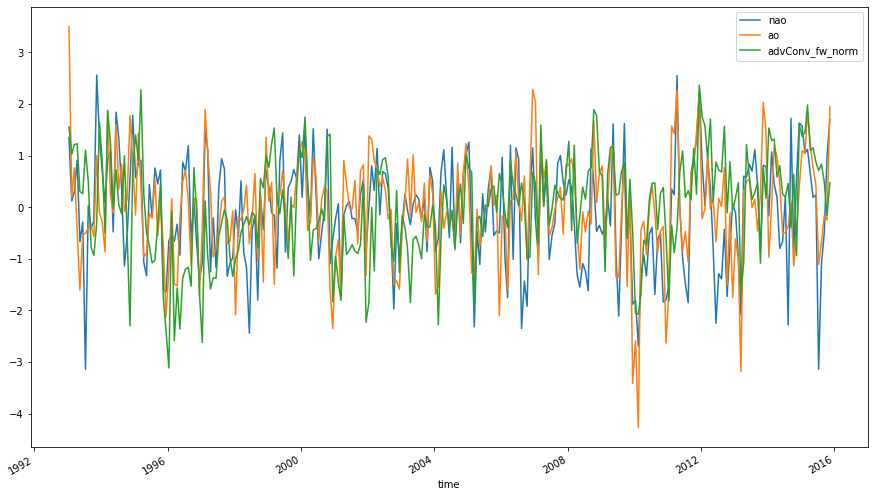

In [18]:
df_sub[['nao','ao','advConv_fw_norm']].plot(figsize=(15,9))

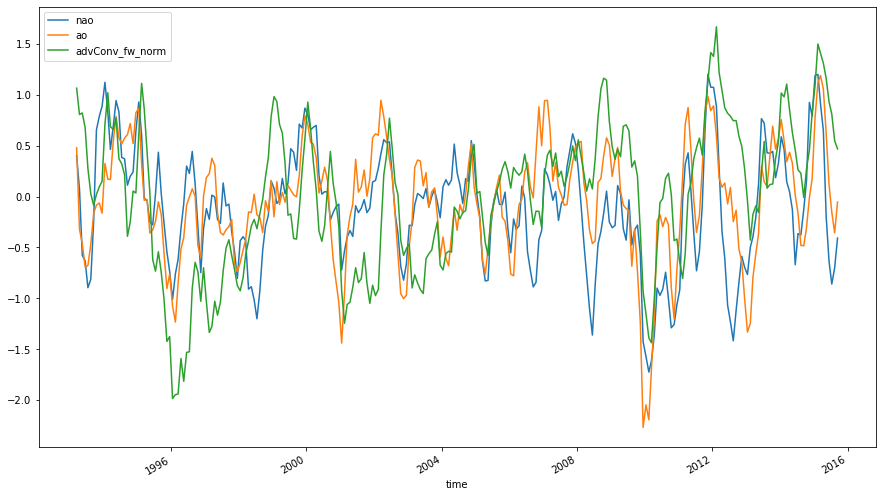

In [19]:
df_sub.rolling(window=5,center=True).mean()[['nao','ao','advConv_fw_norm']].plot(figsize=(15,9))

In [21]:
advConv = (df_ht.total - df_ht.total.mean())/df_ht.total.std()

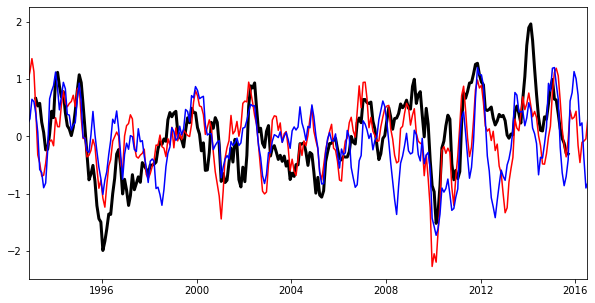

In [22]:
plt.figure(figsize=(10,5))
plt.plot(df_ht.time, -advConv.rolling(window=5,center=True).mean(), lw=3, color='k', linestyle='-')
plt.plot(df_cidx.time, df_cidx.ao.rolling(window=5,center=True).mean(), color='r',linestyle='-')
plt.plot(df_cidx.time, df_cidx.nao.rolling(window=5,center=True).mean(), color='b',linestyle='-')
plt.xlim([date(1992, 11, 30), date(2016, 7, 1)])
plt.show()